# EN3150 Assignment 03: Simple convolutional neural network to perform classification.

Done by:

- Alahakoon U.M.Y.B. (210027C)
- Dulnath
- Jayakumar W.S. (210236P)
- Ratnayake

Instructed by: Dr. Sampath K. Perera

In this assignemnt, our focus is to create a simple image classifier using convolutional neural networks (CNN).

### Import necessary packages

In [28]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from torchinfo import summary
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision.datasets import ImageFolder
import random
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 32
print(device)

cuda


In [3]:
full_dataset = ImageFolder(root='Realwaste', transform=transforms.Compose([
    transforms.Resize((131, 131)),
    transforms.ToTensor()
]))
print(full_dataset.classes)
print(len(full_dataset))

['Cardboard', 'Food Organics', 'Glass', 'Metal', 'Miscellaneous Trash', 'Paper', 'Plastic', 'Textile Trash', 'Vegetation']
4752


In [35]:
train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [int(len(full_dataset) * 0.6), 
                                                                                          int(len(full_dataset) * 0.2), 
                                                                                          len(full_dataset) - int(len(full_dataset) * 0.6) - int(len(full_dataset) * 0.2)])
print(len(train_dataset))
print(len(valid_dataset))
print(len(test_dataset))

test_targets = [test_dataset.dataset.targets[i] for i in test_dataset.indices]

2851
950
951


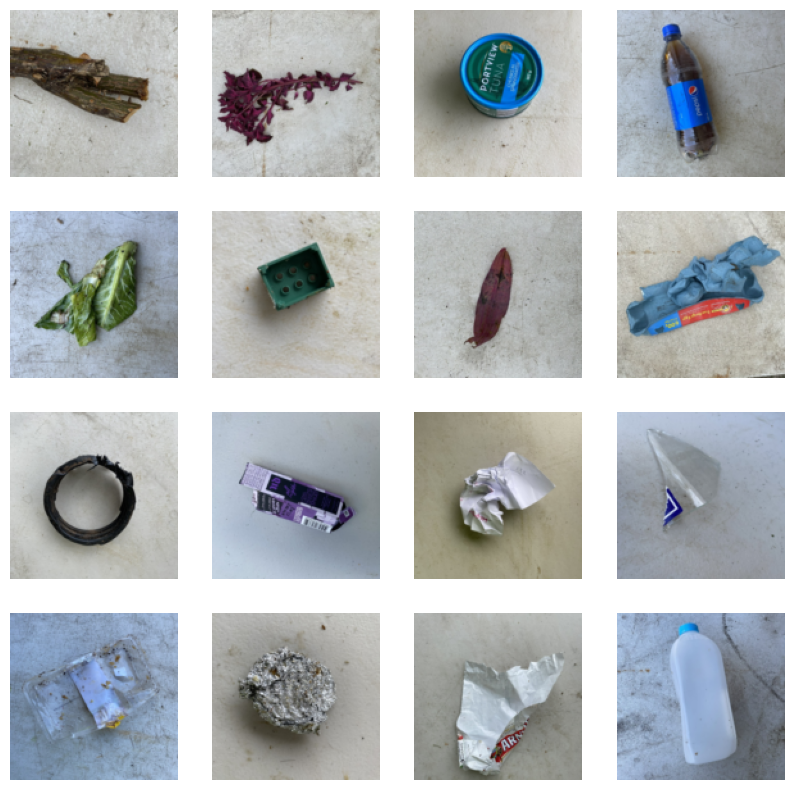

In [5]:
random_indices = random.sample(range(len(train_dataset)), 16)
fig, axs = plt.subplots(4, 4, figsize=(10, 10))
for i, idx in enumerate(random_indices):
    img = train_dataset[idx][0]
    ax = axs[i//4, i%4]
    ax.imshow(img.permute(1, 2, 0))
    ax.axis("off")
plt.show()

In [6]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [19]:
class cnn_model(nn.Module):
    def __init__(self):
        super(cnn_model, self).__init__()
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.flatten = nn.Flatten()
        self.classifier = nn.Sequential(
            nn.Linear(64 * 14 * 14, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(32, 9)
        )
        
    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.flatten(x)
        x = self.classifier(x)
        return x

In [13]:
def train(model:nn.Module,
          trainloader:torch.utils.data.DataLoader,
          testloader:torch.utils.data.DataLoader,
          iterations:int,
          optimizer:torch.optim.Optimizer,
          loss_fn:torch.nn.Module,
          device: torch.device) -> tuple:
    train_accuracy_hist = [ ]
    test_accuracy_hist = [ ]
    train_loss_hist = [ ]
    test_loss_hist = [ ]
    for t in range(iterations):
        model.train()
        accuracy = 0
        running_loss = 0.0
        for _, data in enumerate(trainloader, 0):
            inputs, labels = data
            x_train, y_train = inputs.to(device), labels.to(device)
            y_pred = model(x_train)
            loss_val = loss_fn(y_pred, y_train)
            running_loss += loss_val.item()
            optimizer.zero_grad()
            loss_val.backward()
            optimizer.step()
            _, predicted = torch.max(y_pred, 1)
            accuracy += (predicted == y_train).sum().item()
        train_accuracy_hist.append(accuracy / len(trainloader.dataset))
        train_loss_hist.append(running_loss / len(trainloader))
        model.eval()
        with torch.inference_mode():
            accuracy = 0
            running_loss = 0.0
            for i, data in enumerate(testloader, 0):
                inputs, labels = data
                x_test, y_test = inputs.to(device), labels.to(device)
                y_pred = model(x_test)
                loss_val = loss_fn(y_pred, y_test)
                running_loss += loss_val.item()
                _, predicted = torch.max(y_pred, 1)
                accuracy += (predicted == y_test).sum().item()
            test_accuracy_hist.append(accuracy / len(testloader.dataset))
            test_loss_hist.append(running_loss / len(testloader))
        print(f"Epoch {t + 1} / {iterations}, Train Loss: {train_loss_hist[-1]}, Test Loss: {test_loss_hist[-1]}, Train Accuracy: {train_accuracy_hist[-1]}, Test Accuracy: {test_accuracy_hist[-1]}")
    return train_accuracy_hist, test_accuracy_hist, train_loss_hist, test_loss_hist

In [20]:
model = cnn_model().to(device)
print(summary(cnn_model(), input_size=(BATCH_SIZE, 3, 131, 131)))

Layer (type:depth-idx)                   Output Shape              Param #
cnn_model                                [32, 9]                   --
├─Sequential: 1-1                        [32, 16, 64, 64]          --
│    └─Conv2d: 2-1                       [32, 16, 129, 129]        448
│    └─ReLU: 2-2                         [32, 16, 129, 129]        --
│    └─MaxPool2d: 2-3                    [32, 16, 64, 64]          --
├─Sequential: 1-2                        [32, 32, 31, 31]          --
│    └─Conv2d: 2-4                       [32, 32, 62, 62]          4,640
│    └─ReLU: 2-5                         [32, 32, 62, 62]          --
│    └─MaxPool2d: 2-6                    [32, 32, 31, 31]          --
├─Sequential: 1-3                        [32, 64, 14, 14]          --
│    └─Conv2d: 2-7                       [32, 64, 29, 29]          18,496
│    └─ReLU: 2-8                         [32, 64, 29, 29]          --
│    └─MaxPool2d: 2-9                    [32, 64, 14, 14]          --
├─Flatt

In [21]:
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0005, weight_decay = 0.0001)
iterations = 20

In [22]:
train_accuracy_hist, test_accuracy_hist, train_loss_hist, test_loss_hist = train(model, train_dataloader, valid_dataloader, iterations, optimizer, loss, device)

Epoch 1 / 20, Train Loss: 2.1661964575449626, Test Loss: 2.1403957764307657, Train Accuracy: 0.18028761837951596, Test Accuracy: 0.1831578947368421
Epoch 2 / 20, Train Loss: 2.119037249353197, Test Loss: 2.0356416424115498, Train Accuracy: 0.2188705717292178, Test Accuracy: 0.24421052631578946
Epoch 3 / 20, Train Loss: 2.022755719555749, Test Loss: 1.9367048343022664, Train Accuracy: 0.2546474921080323, Test Accuracy: 0.3094736842105263
Epoch 4 / 20, Train Loss: 1.9465037782986958, Test Loss: 1.8567832430203757, Train Accuracy: 0.29849175727814803, Test Accuracy: 0.3389473684210526
Epoch 5 / 20, Train Loss: 1.8892414702309503, Test Loss: 1.7825782616933188, Train Accuracy: 0.3090143809189758, Test Accuracy: 0.36210526315789476
Epoch 6 / 20, Train Loss: 1.8310674839549594, Test Loss: 1.7374553640683492, Train Accuracy: 0.33988074359873727, Test Accuracy: 0.38842105263157894
Epoch 7 / 20, Train Loss: 1.7923274318377176, Test Loss: 1.694742786884308, Train Accuracy: 0.35426166257453523, T

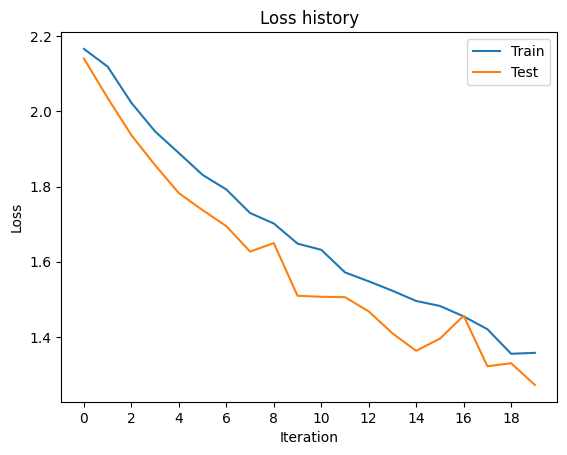

In [24]:
plt.plot(train_loss_hist, label='Train')
plt.plot(test_loss_hist, label='Test')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.xticks(range(0, iterations, 2))
plt.title('Loss history')
plt.legend()
plt.show()

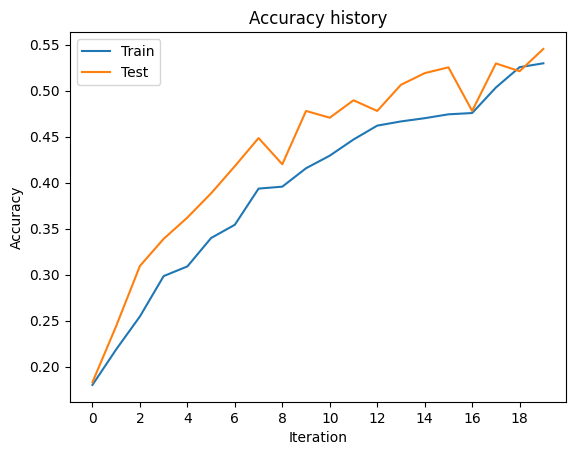

In [25]:
plt.plot(train_accuracy_hist, label='Train')
plt.plot(test_accuracy_hist, label='Test')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.xticks(range(0, iterations, 2))
plt.title('Accuracy history')
plt.legend()
plt.show()

In [26]:
def calculate_accuracy(model: nn.Module, dataloader: torch.utils.data.DataLoader) -> float:
    correct = 0
    total = 0
    predictions = []
    with torch.no_grad():
        for data in dataloader:
            inputs, labels = data
            x, y = inputs.to(device), labels.to(device)
            outputs = model(x)
            _, predicted = torch.max(outputs, 1)
            predictions.append(predicted)
            total += y.size(0)
            correct += (predicted == y).sum().item()
    return 100 * correct / total, torch.cat(predictions)

Test accuracy: 52.786540483701366%


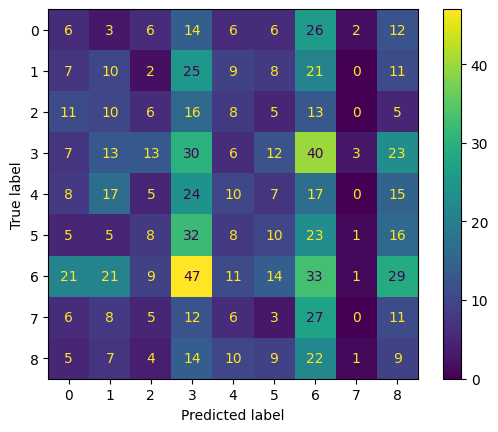

In [37]:
test_accuracy, test_predictions = calculate_accuracy(model, test_dataloader)
print(f"Test accuracy: {test_accuracy}%")

cm = confusion_matrix(test_targets, test_predictions.cpu())
ConfusionMatrixDisplay(cm).plot()

In [14]:
train_accuracy = calculate_accuracy(model, train_dataloader)
test_accuracy = calculate_accuracy(model, test_dataloader)

print(f"Train accuracy: {train_accuracy:.2f}%")
print(f"Test accuracy: {test_accuracy:.2f}%")

Train accuracy: 82.21%
Test accuracy: 62.83%


In [ ]:
torch.save(model.state_dict(), 'model.pth')